In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pygimli as pg
import pygimli.meshtools as mt
import pygimli.physics.traveltime as tt

pg.utils.units.quants['vel']['cMap'] = 'jet'

In [2]:
waterdepth = 3.75

In [3]:
# Acquisition parameters
bh_spacing = 30
bh_length = 40
sensor_spacing = 2.4

depth = -np.arange(waterdepth, bh_length, sensor_spacing)

sensors = np.zeros((len(depth) * 2, 2))  # two boreholes
sensors[len(depth):, 0] = bh_spacing  # x
sensors[:, 1] = np.hstack([depth] * 2)  # y
sensors

array([[  0.  ,  -3.75],
       [  0.  ,  -6.15],
       [  0.  ,  -8.55],
       [  0.  , -10.95],
       [  0.  , -13.35],
       [  0.  , -15.75],
       [  0.  , -18.15],
       [  0.  , -20.55],
       [  0.  , -22.95],
       [  0.  , -25.35],
       [  0.  , -27.75],
       [  0.  , -30.15],
       [  0.  , -32.55],
       [  0.  , -34.95],
       [  0.  , -37.35],
       [  0.  , -39.75],
       [ 30.  ,  -3.75],
       [ 30.  ,  -6.15],
       [ 30.  ,  -8.55],
       [ 30.  , -10.95],
       [ 30.  , -13.35],
       [ 30.  , -15.75],
       [ 30.  , -18.15],
       [ 30.  , -20.55],
       [ 30.  , -22.95],
       [ 30.  , -25.35],
       [ 30.  , -27.75],
       [ 30.  , -30.15],
       [ 30.  , -32.55],
       [ 30.  , -34.95],
       [ 30.  , -37.35],
       [ 30.  , -39.75]])

Kolom dalam file Excel: ['layer', 'x', 'y']
Membuat layer 1 dengan 11 titik
Membuat layer 2 dengan 22 titik
Membuat layer 3 dengan 11 titik
Membuat layer 4 dengan 4 titik
Membuat layer 5 dengan 4 titik
Berhasil membuat 5 layer


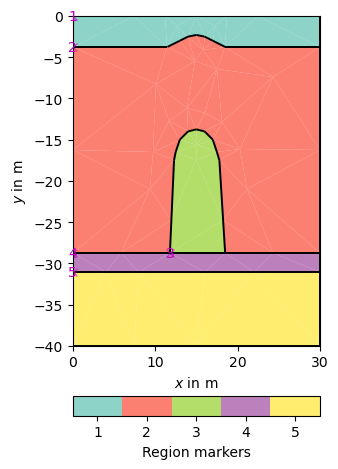

In [4]:
# Baca data dari file Excel
df = pd.read_excel('Salt Diapir 1.xlsx')  # Ganti dengan nama file Anda

# Tampilkan nama kolom untuk memastikan
print("Kolom dalam file Excel:", df.columns.tolist())

# Kelompokkan data - sesuaikan nama kolom jika berbeda
layers_data = {}

for _, row in df.iterrows():
    # Sesuaikan nama kolom berdasarkan output di atas
    layer_id = row.iloc[0]  # Kolom pertama (layer)
    x = row.iloc[1]         # Kolom kedua (X)
    y = row.iloc[2]         # Kolom ketiga (Y)
    
    if pd.notna(layer_id):  # Jika layer ID valid
        layer_id = int(layer_id)
        if layer_id not in layers_data:
            layers_data[layer_id] = []
        
        if pd.notna(x) and pd.notna(y):  # Pastikan koordinat valid
            layers_data[layer_id].append([x, y])

# Buat polygon untuk setiap layer
geom = None
for marker, points in layers_data.items():
    print(f"Membuat layer {marker} dengan {len(points)} titik")
    layer = mt.createPolygon(points, isClosed=True, marker=marker)
    if geom is None:
        geom = layer
    else:
        geom += layer

# Tampilkan hasil
if geom:
    pg.show(geom)
    print(f"Berhasil membuat {len(layers_data)} layer")
else:
    print("Tidak ada geometri yang dibuat")

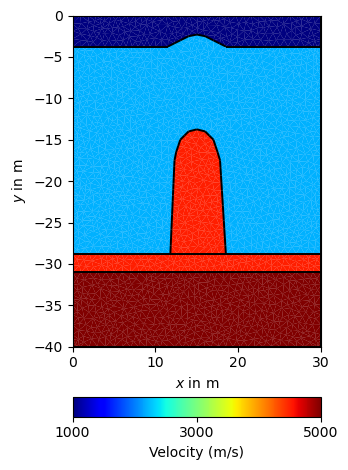

In [5]:
for sen in sensors:
    geom.createNode(sen)

mesh_fwd = mt.createMesh(geom, quality=32, area=0.5)
model = np.array([2200, 1000, 2200, 4500, 4500, 5000])[mesh_fwd.cellMarkers()]
ax, cb = pg.show(mesh_fwd, model, logScale=False,
                 label=pg.unit('vel'), cMap=pg.cmap('vel'), nLevs=3)

In [6]:
scheme = tt.createCrossholeData(sensors)

19/10/25 - 17:26:02 - pyGIMLi - INFO - Creating refined mesh (secnodes: 4) to solve forward task.


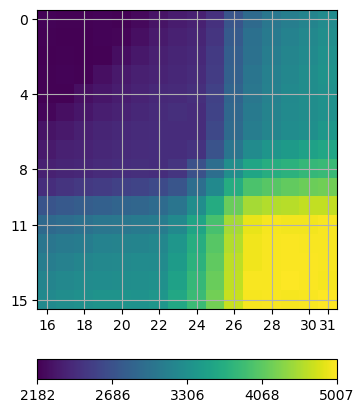

In [7]:
mgr = tt.TravelTimeManager()
data = tt.simulate(mesh=mesh_fwd, scheme=scheme, slowness=1./model,
                   secNodes=4, noiseLevel=0.0015, noiseAbs=1e-5, seed=1337)

ax, cb = tt.showVA(data, usePos=False)

19/10/25 - 17:26:30 - pyGIMLi - INFO - Found 1 regions.
19/10/25 - 17:26:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
19/10/25 - 17:26:30 - pyGIMLi - INFO - Creating refined mesh (secnodes: 3) to solve forward task.
19/10/25 - 17:26:30 - pyGIMLi - INFO - Create constant starting model: 0.00032633404973102465
19/10/25 - 17:26:30 - pyGIMLi - INFO - Created startmodel from forward operator:825, min/max=0.000326/0.000326
19/10/25 - 17:26:30 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.traveltime.modelling.TravelTimeDijkstraModelling object at 0x0000020D162A0310>
Data transformation: Identity transform
Model transformation: Logarithmic transform
min/max (data): 0.006/0.02
min/max (error): 0.21%/0.32%
min/max (start model): 3.3e-04/3.3e-04
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 10204.07
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =  354.13 (dPhi = 96.36%) lam: 1000.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   27.96 (dPhi = 87.82%) lam: 1000.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    6.28 (dPhi = 56.71%) lam: 1000.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    2.86 (dPhi = 22.15%) lam: 1000.0
----------------------------------------------------

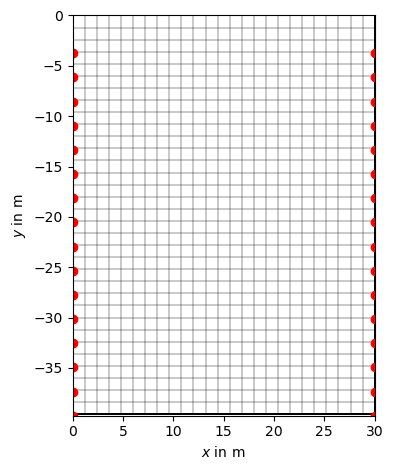

In [8]:
refinement = 0.5
x = np.arange(0, bh_spacing + refinement, sensor_spacing * refinement)
y = -np.arange(0.0, bh_length, sensor_spacing * refinement)
mesh = pg.meshtools.createGrid(x, y)

ax, _ = pg.show(mesh, hold=True)
ax.plot(sensors[:, 0], sensors[:, 1], "ro")

invmodel = mgr.invert(data, mesh=mesh, secNodes=3, lam=1000, zWeight=1.0,
                      useGradient=False, verbose=True)
print("chi^2 = {:.2f}".format(mgr.inv.chi2()))  # Look at the data fit

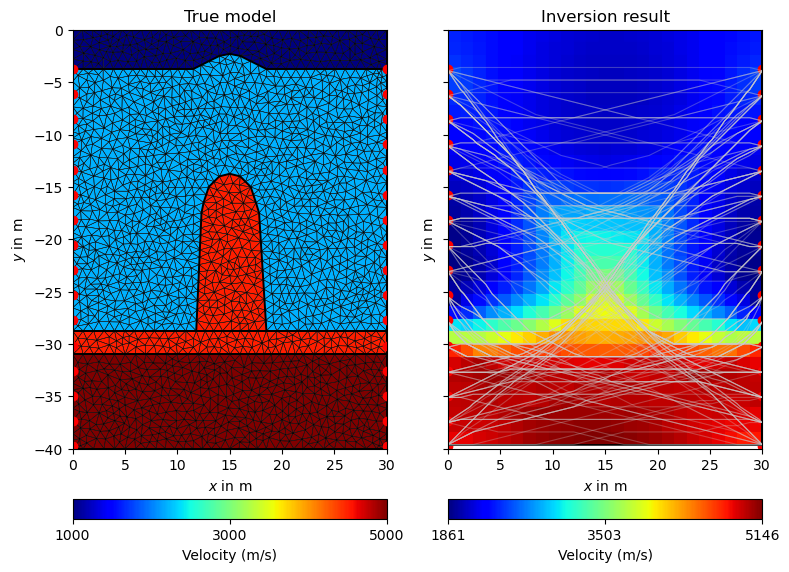

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 7), sharex=True, sharey=True)
ax1.set_title("True model")
ax2.set_title("Inversion result")

ax, cb = pg.show(mesh_fwd, model, ax=ax1, showMesh=True,
                 label=pg.unit('vel'), cMap=pg.cmap('vel'), nLevs=3)

for ax in (ax1, ax2):
    ax.plot(sensors[:, 0], sensors[:, 1], "ro")

mgr.showResult(ax=ax2, logScale=False, nLevs=3)
mgr.drawRayPaths(ax=ax2, color="0.8", alpha=0.3)
fig.tight_layout()

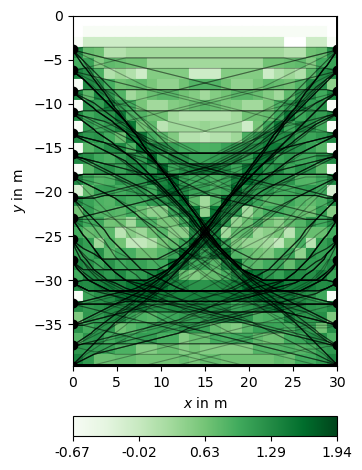

In [10]:
fig, ax = plt.subplots()
mgr.showCoverage(ax=ax, cMap="Greens")
mgr.drawRayPaths(ax=ax, color="k", alpha=0.3)
p = ax.plot(sensors[:, 0], sensors[:, 1], "ko")